# Real-World Example: Hydrographic Trends in the Baltic Sea

We'll see that in an Ocean model covering the Baltic Sea, there is a long-term trend for the basin- wide hydrography which is overlayed by decadal variability in the deepest parts of the Gotland Basin.

## First, load relevant modules and make sure figures look nice

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style("darkgrid")
sns.set_context("talk")

## Then, load the data and crop them to the Baltic Sea

In [4]:
file_name = "data/baltic_hydrography/INSPIRE_1979_2016_annual_oce_surf_and_bottom_hydrograhy.nc"

ds = xr.open_dataset(file_name)

ds = ds.sel(lon=slice(9, None))  # East of 9°E

display(ds)

<xarray.Dataset>
Dimensions:  (lat: 538, lon: 475, time: 38)
Coordinates:
  * lon      (lon) float32 9.0225 9.0675 9.1125 9.1575 9.2025 9.2475 9.2925 ...
  * lat      (lat) float32 53.8225 53.845 53.8675 53.89 53.9125 53.935 ...
  * time     (time) datetime64[ns] 1979-12-31 1980-12-31 1981-12-31 ...
Data variables:
    BTEMP    (time, lat, lon) float32 ...
    SSS      (time, lat, lon) float32 ...
    BSALT    (time, lat, lon) float32 ...
    SST      (time, lat, lon) float32 ...
Attributes:
    history:  Created from monthly INSPIRE fields weighting all months equally.

## Have a first look: Sea-Surface Temperature

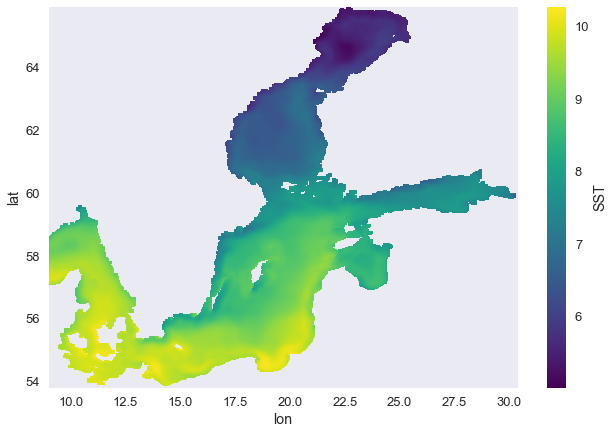

In [5]:
ds.SST.mean("time").plot(size=7);

## Have a second look: Data ranges

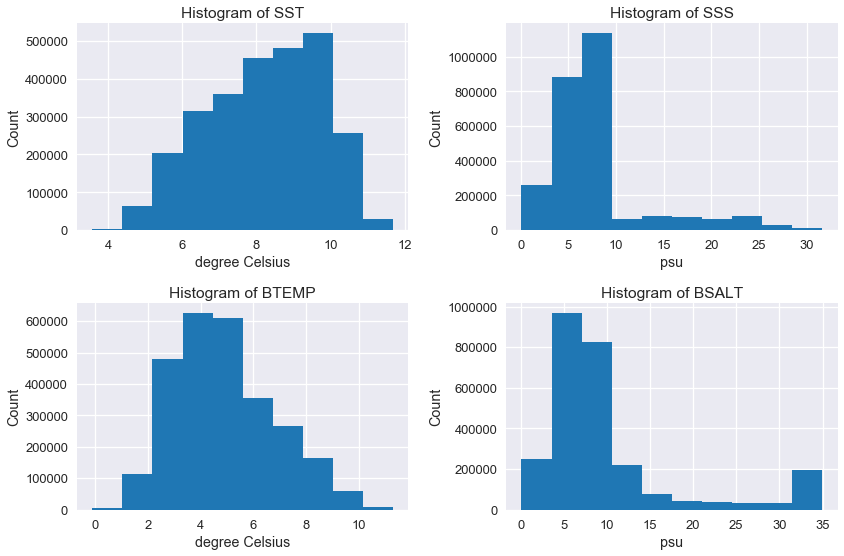

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

for iter_ax, vname in zip(ax.flat, ["SST", "SSS", "BTEMP", "BSALT"]):
    
    # plot histogram for each variable
    ds[vname].plot.hist(ax=iter_ax);
    
    # add meaning to the horizontal axis
    iter_ax.set_xlabel(ds[vname].units)

fig.tight_layout()

## Calculate and visualize long-term trends

For calculating long-term trends, we'll need a horizontal average that accounts for the size of the grid boxes and a function wrapping a polynomial fit.

## Auxiliary functions

(If you're reading this for the first time, skip to [the plots](#The-plots).)

### Weighted horizontal mean

We need a way of weighting the contribution of each grid box to the basin-wide mean according to the area covered by it.  The zonal (longitudinal) extent of a grid box is proportional to the cosine of the latitude

$$\cos(lat)$$

(i.e., smaller grid boxes further north).  Then, with the weight determined, we calculate the basin-wide mean for, e.g., sea-surface temperature (SST) as

$$\frac{\sum\limits_{lat, lon} SST(t, lon, lat) \cos(lat)}{\sum\limits_{lat, lon}\cos(lat)}$$

But we need to make sure that also in the denominator, we only sum over those positions that belong valid (i.e., non-land) data points.

In [7]:
def _weighted_horizontal_mean(da):
    
    # calculate the cosine of the latitude (which is only "living" in one dimension (lat))
    lat = da.coords["lat"]   
    cos_lat = xr.ufuncs.cos(xr.ufuncs.deg2rad(lat))
    
    # broadcast the 1d data to the full domain covered by the higher-dimensional `da`
    #
    # (This will return the cosine of the latitude only where da is _not_ null / invalid)
    cos_lat = cos_lat.where(xr.ufuncs.logical_not(da.isnull()))
    
    # calculate the weighted mean as sum(var * weight)/sum(weight)
    weighted_mean = (cos_lat  * da).sum(dim=["lat", "lon"]) / cos_lat.sum(dim=["lat", "lon"])
    
    return weighted_mean.rename(da.name)

### Polynomial (linear order) fit

We use Numpy's `polyfit` and ` polyval` to fit a line (first-order polynomial) to a data time series.  For this (as numpy does not necessarily understand our time axis), we need a way of getting the time data as a floating point number of seconds since the beginning of the time series.  This is what `_get_time_in_seconds` is for.

The polynomial fit is calculated in `_get_trend`, where first, the time-axis of the data array `da`  is converted to seconds and then normalized to count the number of decades since the beginning of the time series.  We use the `xr.DataArray`  constructor to create a properly annotated data array from the fitted polynomial.

In [8]:
def _get_time_in_seconds(time):
    if time.ndim != 0:
        time = (time - time[0]).data
    time = time.astype("timedelta64[s]").astype("float")
    return time


def _get_trend(da):
    time = _get_time_in_seconds(da.coords["time"])
    
    one_decade = _get_time_in_seconds(np.timedelta64(10, "Y"))
    time /= one_decade
    
    z = np.polyfit(time, da.data, 1)

    da_trend = xr.DataArray(np.polyval(z, time),
                            coords=da.coords, dims=da.dims,
                            name=(da.name + "_trend"))
    
    slope = z[0]
    
    total_diff = z[0] * time[-1]
    
    return da_trend, slope, total_diff

## The plots

Now that we have the [auxiliary functions](#Auxiliary-functions), lets iterate over all the variables we're interested in and plot the raw time series together with their linear trends.

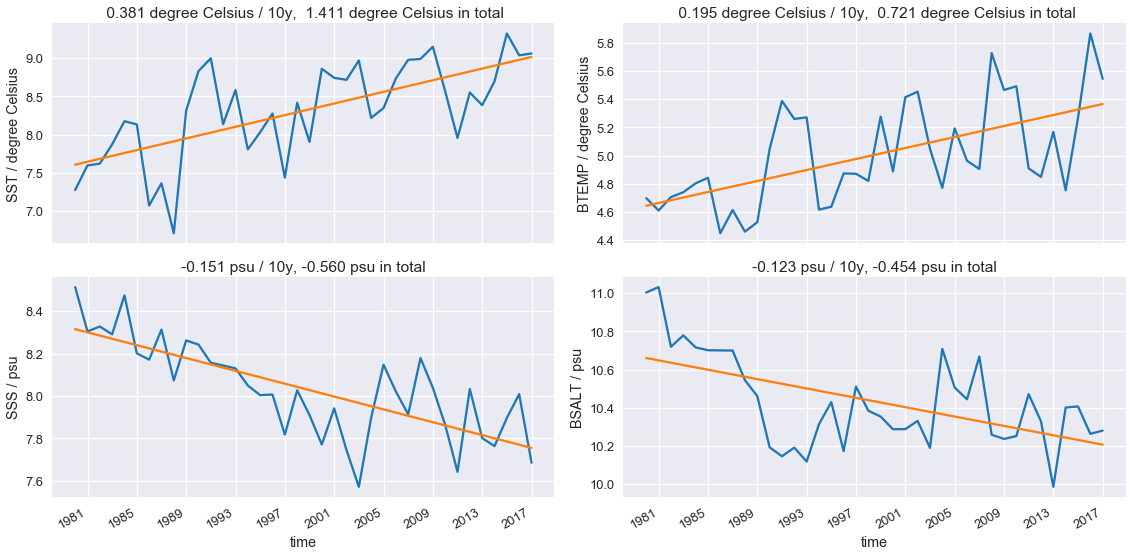

In [9]:
fig, ax_arr = plt.subplots(2, 2, sharex=True, figsize=(16, 8))

for ax, vname in zip(ax_arr.flat, ["SST", "BTEMP", "SSS", "BSALT"]):

    v = ds[vname]
    
    v_mean = _weighted_horizontal_mean(v)
    v_mean.plot(ax=ax);

    v_trend, slope, total_diff = _get_trend(v_mean)
    v_trend.plot(ax=ax);
    
    ax.set_title(
        "{slope: .3f} {units} / 10y, {total: .3f} {units} in total".format(
            name=v.name, slope=slope, total=total_diff, units=v.units))
    ax.set_ylabel("{} / {}".format(v.name, v.units));

fig.tight_layout();

## Variability in the deep Gotland basin

As our data does not contain any depth coordinate, we'll detect the deep layers by exploiting the fact that the amplitude of temperature variations reduces with depth.  Trying different thresholds, we found that the deepest part are well-isolated if we require the standard deviation of the bottom-temperature time series to be smaller than 3 K.

In addition to the criterion of damped variability of temperature, we restrict the region to the boundaries of the Gotland basin.

In [10]:
# define boolean mask for deep Gotland basin waters (This is an Xarray DataArray.)
deep_gotland = (
    (ds.BTEMP.std("time") < 0.3) &
    (ds.coords["lat"] < 59.5) &
    (ds.coords["lon"] < 22.0))

deep_gotland = deep_gotland.rename("deep Gotland basin waters")

In [11]:
# Add the deep-gotland basin mask to the data set
ds["deep_gotland"] = deep_gotland

In [12]:
# plot the mask with temperature variability

# ...

---
---

Now that we have a mask for the desired region, we extract bottom temperature and salinity for the region:

In [13]:
# This time, we directly create the data arrays as part of the data set.
ds["BTEMP_DG"] = ds.BTEMP.where(ds.deep_gotland)
ds["BSALT_DG"] = ds.BSALT.where(ds.deep_gotland)

And we plot the deep-Gotland-basin time series:

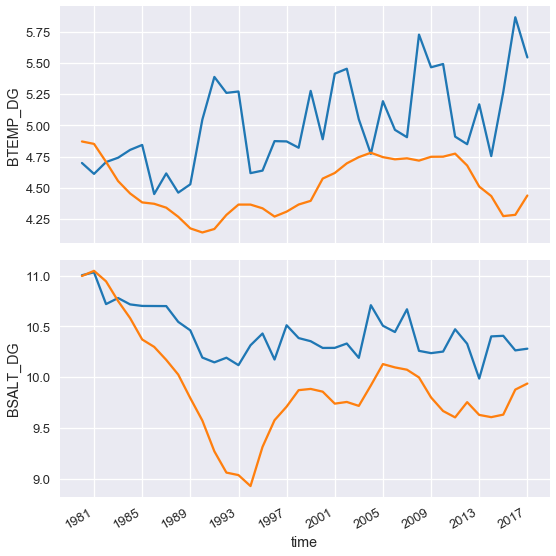

In [14]:
fig, ax_arr = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

for tmp_ax, vname in zip(ax_arr.flat, [vn for vn in ["BTEMP", "BSALT"]]):
    
    v = ds[vname]
    v_dg = ds[vname + "_DG"]
    
    # plot for whole basin
    v_mean = _weighted_horizontal_mean(v)
    v_mean.plot(ax=tmp_ax, label="whole basin");
    
    # plot for dg only
    v_dg_mean = _weighted_horizontal_mean(v_dg)
    v_dg_mean.plot(ax=tmp_ax, label="Gotland basin");

    # add units to the y-axis labels (and note that the units are already
    # an attribute of the variables plotted here)
    
    # tmp_ax.set_ylabel( ...
    
    # also add a legend 
    
    # ...

fig.tight_layout();

---
---

## Produce a map projection with the data

We use [cartopy](http://scitools.org.uk/cartopy/docs/latest/) to create a map with land masses and borders.

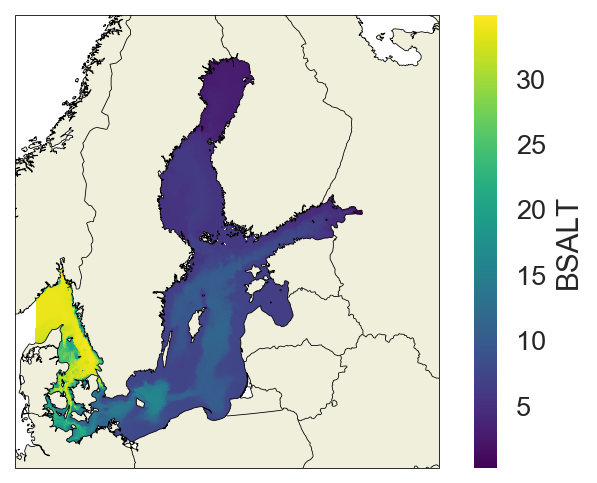

In [15]:
import cartopy.crs as ccrs
import cartopy.feature as feature

plt.rcParams["figure.dpi"] = 150

ax = plt.axes(projection=ccrs.Orthographic(10, 54))

ds.BSALT.mean("time").plot(ax=ax, transform=ccrs.PlateCarree())

land_masses = feature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='k',
    facecolor=feature.COLORS['land'])
ax.add_feature(land_masses)

borders = feature.NaturalEarthFeature(
    'cultural', 'admin_0_boundary_lines_land', '10m',
    edgecolor='k',
    facecolor='none')
ax.add_feature(borders);

Note that Cartopy will try to download the high-resolution shape files containing info on the coast line and admin borders from <https://naturalearthdata.com>.  If you plan to use Cartopy behind a firewall that prohibits direct access to the internet or, e.g., on a ship with poor internet connectivity, the [cartopy_offlinedata package](https://git.geomar.de/open-source/cartopy_offlinedata/) helps pointing cartopy to a local copy of the data.

## Key concepts from this notebook

- loading (netCDF) data into an Xarray Dataset
- inspecting and plotting data
- reductions and ufuncs
- organizing code into functions, loops, etc.
- masking data
- string formatting
- map projections